In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits

import scipy.stats

from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck18')

In [2]:
plt.style.use('notebook')

## Load catalog & definitions

In [3]:
t = Table.read('../data/rcat.fits')
ind = np.isfinite(t['GAIADR2_PMRA']) & (t['FLAG']==0) & (t['SNR']>10) & (t['E_tot_pot1']<0)
t = t[ind]
print(len(t))

age = 10**t['logAge']*1e-9
age_lerr = age - 10**(t['logAge']-t['logAge_lerr'])*1e-9
age_uerr = 10**(t['logAge']+t['logAge_uerr'])*1e-9 - age
age_err = 0.5 * (age_lerr + age_uerr)
age_err_cons = np.maximum(age_lerr, age_uerr)
age_err_min = 1
age_err_cons[age_err_cons<age_err_min] = age_err_min
age_invar = (age_err_cons)**-2

/usr/lib64/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/usr/lib64/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


27962


In [4]:
# blue = '#0039d3'
# purple = '#4700d3'
# orange = '#ff6200'
# pink = '#ee0449'

blue = '#0043c7'
orange = '#db3700'
gold = '#ffa006'

In [5]:
ind_all = np.ones(len(t), dtype='bool')
ind_z = (np.abs(t['Z_gal'])<1)
loggmin, loggmax = 3.8, 4.3
ind_safeage = (t['logg']>loggmin) & (t['logg']<loggmax) #& (t['logg_err']<0.1)
# ind_safeage = (t['logg']>3.8) & (t['logg']<4.3) & (age_err/age<0.15)
print(np.sum(ind_safeage))

11034


In [6]:
ind_highe = (t['eccen_pot1']>0.75)
ind_lowe = (t['eccen_pot1']<0.25)

p_ge = [-0.32,-0.02]
poly_ge = np.poly1d(p_ge)

p_splash = [-0.14,0.18]
poly_splash = np.poly1d(p_splash)

p_lowa = [-0.14,0.15]
poly_lowa = np.poly1d(p_lowa)

ind_lowachem = (t['init_FeH']>-0.45) & (t['init_aFe']<poly_lowa(t['init_FeH']))
ind_lowa = ind_lowe & ind_lowachem

ind_mpoor = (t['init_FeH']<-0.6) & (t['init_aFe']<poly_ge(t['init_FeH']))
ind_ge = ind_mpoor & ind_highe

ind_tdchem = (t['init_FeH']>-0.75) & (t['init_aFe']>poly_splash(t['init_FeH']))
ind_splash = ind_tdchem & ind_highe
ind_thick = ind_tdchem & (t['eccen_pot1']<0.5)

## Figure 2: chemistry definitions

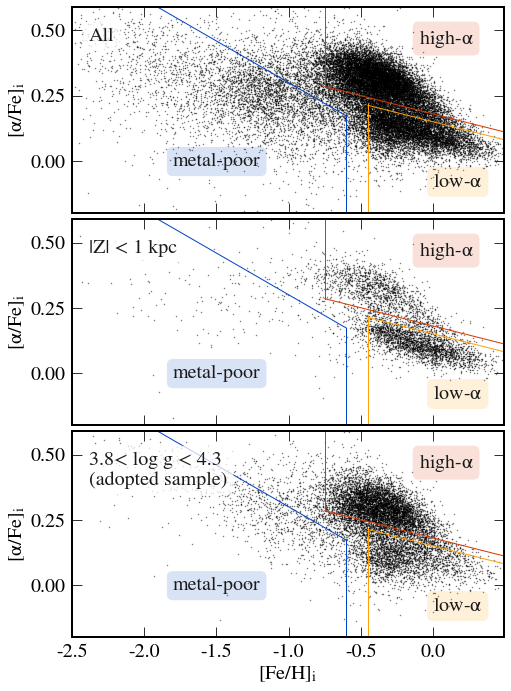

In [7]:
x_ge = np.linspace(-2, -0.6, 30)
y_ge = poly_ge(x_ge)

x_splash = np.linspace(-0.75, 0.5, 30)
y_splash = poly_splash(x_splash)

x_lowa = np.linspace(-0.45, 0.5, 30)
y_lowa = poly_lowa(x_lowa)

afeh_panels = ['All', '|Z| < 1 kpc', '{:.1f}< log g < {:.1f}\n(adopted sample)'.format(loggmin, loggmax)]
lw = 1

fig, ax = plt.subplots(3,1,figsize=(7.5,10), sharex=True, sharey=True)

for e, ind in enumerate([ind_all, ind_z, ind_safeage]):
    plt.sca(ax[e])
    plt.plot(t['init_FeH'][ind], t['init_aFe'][ind], 'ko', mew=0, ms=1.5, alpha=0.5, rasterized=True, zorder=0)

    plt.plot(x_ge, y_ge, '-', color=blue, label='', lw=lw)
    plt.plot([-0.6, -0.6], [-0.2, poly_ge(-0.6)], '-', color=blue, label='', lw=lw)
    plt.plot(x_splash, y_splash, '-', color=orange, label='', lw=lw)
    plt.plot([-0.75, -0.75], [poly_splash(-0.75), 0.6], '-', color=orange, label='', lw=lw)
    plt.plot(x_lowa, y_lowa, '-', color=gold, label='', lw=lw)
    plt.plot([-0.45, -0.45], [-0.2, poly_lowa(-0.5)], '-', color=gold, label='', lw=lw)
    
    plt.text(-0.1, 0.45, 'high-$\\alpha$', color='0.1',
         bbox=dict(facecolor=orange, ec='none', alpha=0.15, boxstyle='round', pad=0.3))
    plt.text(0, -0.1, 'low-$\\alpha$', color='0.1',
         bbox=dict(facecolor=gold, ec='none', alpha=0.15, boxstyle='round', pad=0.3))
    plt.text(-1.8, -0.02, 'metal-poor', color='0.1',
             bbox=dict(facecolor=blue, ec='none', alpha=0.15, boxstyle='round', pad=0.3))

    plt.text(0.04, 0.9, afeh_panels[e], color='0.1', transform=plt.gca().transAxes, va='top',
             bbox=dict(facecolor='w', ec='none', alpha=0.75, boxstyle='round', pad=0.3))
    plt.ylabel('[$\\alpha$/Fe]$_i$')

plt.xlim(-2.5,0.49)
plt.ylim(-0.2, 0.59)
plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.25))
plt.xlabel('[Fe/H]$_i$')
plt.tight_layout(h_pad=0.3)
plt.savefig('../paper/afeh_selections.pdf')

## Figure 1: The sample

In [8]:
rcyl = np.sqrt(t['X_gal']**2 + t['Y_gal']**2)

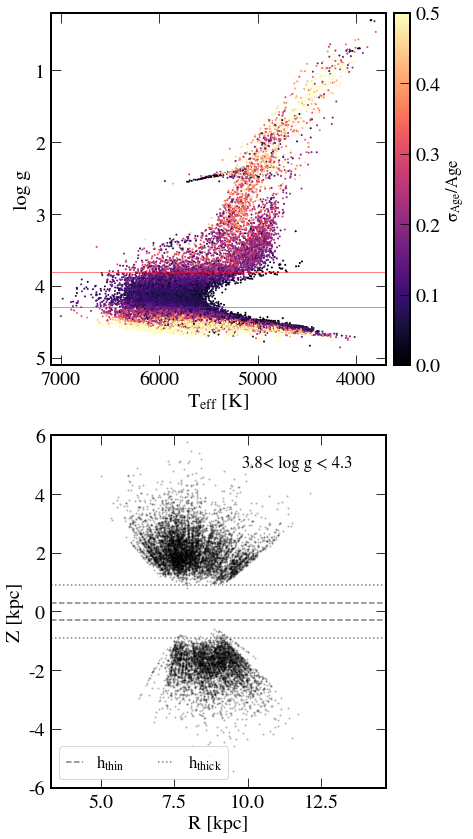

In [9]:
fig, ax = plt.subplots(2,1,figsize=(6,14.25), gridspec_kw=dict(hspace=0.2))

plt.sca(ax[0])
im = plt.scatter(t['Teff'], t['logg'], c=age_err/age, vmin=0, vmax=0.5, s=1, cmap='magma', rasterized=True)
plt.axhline(loggmin, ls='-', color='r', alpha=0.5, lw=1)
plt.axhline(loggmax, ls='-', color='r', alpha=0.5, lw=1)

plt.xlim(7100,3700)
plt.ylim(5.1,0.2)
plt.xlabel('$T_{eff}$ [K]')
plt.ylabel('log g')

pos = plt.gca().get_position()
cax = plt.axes([pos.x1+0.02,pos.y0,0.035,pos.y1 - pos.y0])
plt.colorbar(im, cax=cax) #, ticks=[-5,-2.5,0,2.5,5])
# plt.yticks(fontsize=font_tick)
plt.ylabel('$\sigma_{Age} / Age$', fontsize='small')

plt.sca(ax[1])
plt.plot(rcyl[ind_safeage], t['Z_gal'][ind_safeage], 'ko', mew=0, ms=2, alpha=0.3, label='', rasterized=True)

ls = ['--', ':']
labels = ['$h_{thin}$', '$h_{thick}$']
for e, h in enumerate([0.3, 0.9]):
    plt.axhline(h, color='0.5', ls=ls[e], label=labels[e])
    plt.axhline(-h, color='0.5', ls=ls[e], label='')

plt.text(0.9,0.91,'{:.1f}< log g < {:.1f}'.format(loggmin, loggmax), fontsize='small', transform=plt.gca().transAxes,
        ha='right')
plt.legend(loc=3, fontsize='small', handlelength=1, ncol=2)
plt.ylim(-6,6)
plt.xlim(5,13)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('R [kpc]')
plt.ylabel('Z [kpc]')

# plt.tight_layout()
plt.savefig('../paper/sample.pdf')

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


[0.09986697 0.16064113]


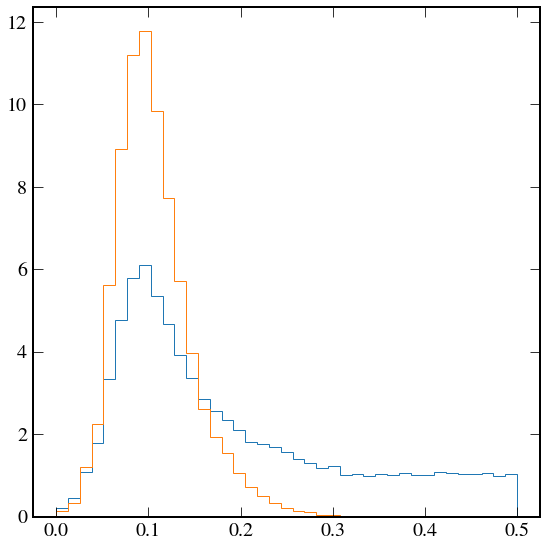

In [10]:
pbins = np.linspace(0,0.5,40)
rel_age = age_err/age
plt.hist(rel_age, bins=pbins, normed=True, histtype='step')
plt.hist(rel_age[ind_safeage], bins=pbins, normed=True, histtype='step')

print(np.percentile(rel_age[ind_safeage], [50,90]))

plt.tight_layout()

In [11]:
np.median(age[ind_safeage & ind_mpoor])

11.77008940508168

In [12]:
np.percentile(t['dist_adpt'][ind_safeage], [1,50,99])

array([1.41115615, 2.44768646, 4.72690176])

## Figure 3: Chemistry vs age & eccentricity

In [13]:
cm_data = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]

In [14]:
cm_data = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846]]

In [15]:
parula_map = mpl.colors.LinearSegmentedColormap.from_list('parula', cm_data[::-1])

/usr/lib64/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(super(), op)(other)
/usr/lib64/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


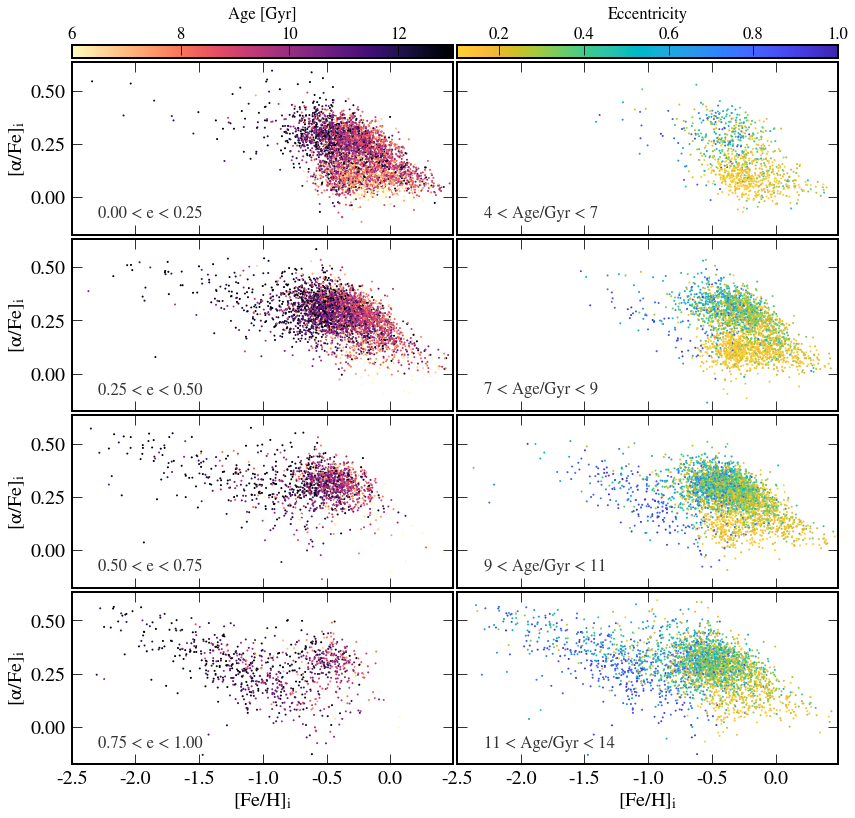

In [16]:
ecc_ranges = np.array([0,0.25,0.5,0.75,1])
age_ranges = np.array([4,7,9,11,14])
Ne = np.size(ecc_ranges) - 1

da = 6
fig, ax = plt.subplots(Ne,2,figsize=(12,11), sharey=True, sharex=True)

for i in range(Ne):
    ind = (t['eccen_pot1']>=ecc_ranges[i]) & (t['eccen_pot1']<ecc_ranges[i+1])
    
    # left column
    plt.sca(ax[i][0])
#     plt.plot(t['init_FeH'][ind_safeage & ind], t['init_aFe'][ind_safeage & ind], 'ko', mew=0, ms=1.5, alpha=0.6,
#             label='', rasterized=True)
    cmap0 = 'magma_r'
    ima = plt.scatter(t['init_FeH'][ind_safeage & ind], t['init_aFe'][ind_safeage & ind], c=age[ind_safeage & ind],
               vmin=6, vmax=13, cmap=cmap0, rasterized=True, s=1, alpha=1)
    
#     # double scatter with alpha=1 to avoid issues with gray lines in the colorbar
#     ima = plt.scatter(t['init_FeH'][ind_safeage & ind]+5, t['init_aFe'][ind_safeage & ind], c=age[ind_safeage & ind],
#                vmin=6, vmax=13, cmap=cmap0, rasterized=True, s=1, alpha=1)
    
    plt.xlim(-2.5,0.49)
    plt.ylabel('[$\\alpha$/Fe]$_i$')
    plt.text(0.07,0.1,'{:.2f} < e < {:.2f}'.format(ecc_ranges[i], ecc_ranges[i+1]), fontsize='small',
            transform=plt.gca().transAxes, color='0.2')
    
    # right column
    plt.sca(ax[i][1])
    ind = (age>=age_ranges[i]) & (age<age_ranges[i+1])
#     plt.plot(t['init_FeH'][ind_safeage & ind], t['init_aFe'][ind_safeage & ind], 'ko', mew=0, ms=1.5, alpha=0.6,
#             label='', rasterized=True)
    cmap = parula_map
    ime = plt.scatter(t['init_FeH'][ind_safeage & ind], t['init_aFe'][ind_safeage & ind],
                c=t['eccen_pot1'][ind_safeage & ind],
               vmin=0.1, vmax=1, cmap=cmap, rasterized=True, s=1, alpha=1)
    
#     # double scatter with alpha=1 to avoid issues with gray lines in the colorbar
#     ime = plt.scatter(t['init_FeH'][ind_safeage & ind]+5, t['init_aFe'][ind_safeage & ind],
#                 c=t['eccen_pot1'][ind_safeage & ind],
#                vmin=0.1, vmax=1, cmap=cmap, rasterized=True, s=1, alpha=1)
    
    plt.text(0.07,0.1,'{:.0f} < Age/Gyr < {:.0f}'.format(age_ranges[i], age_ranges[i+1]), fontsize='small',
            transform=plt.gca().transAxes, color='0.2')
    
for j in range(2):
    plt.sca(ax[Ne-1][j])
    plt.xlabel('[Fe/H]$_i$')

plt.tight_layout(w_pad=0.2, h_pad=0.2)
cmap = 'parula'

plt.sca(ax[0][0])
pos = plt.gca().get_position()
cax_age = plt.axes([pos.x0, pos.y1+0.005, pos.x1 - pos.x0, 0.017])
plt.colorbar(ima, cax=cax_age, orientation='horizontal', ticks=[4,6,8,10,12])
# cbar = plt.colorbar(ima, cax=cax_age, orientation='horizontal', ticks=[7,9,11])
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(fontsize='small', y=0.7)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Age [Gyr]', fontsize='small', labelpad=8)

plt.sca(ax[0][1])
pos = plt.gca().get_position()
cax_ecc = plt.axes([pos.x0, pos.y1+0.005, pos.x1 - pos.x0, 0.017])
cbar = plt.colorbar(ime, cax=cax_ecc, orientation='horizontal', ticks=np.arange(0.2,1.1,0.2))
# cbar = plt.colorbar(ime, cax=cax_ecc, orientation='horizontal', ticks=[0,0.25,0.5,0.75])
# cbar.solids.set_edgecolor('face')
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(fontsize='small', y=0.7)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Eccentricity', fontsize='small', labelpad=8)

# plt.yticks(fontsize=font_tick)
# plt.ylabel('$\sigma_{Age} / Age$', fontsize='small')

# plt.savefig('../plots/afeh_eccen_age_{:s}.png'.format(cmap))
plt.savefig('../paper/afeh_eccen_age.pdf')

In [17]:
print(np.percentile(t['Rapo_pot1'][ind_highe & ind_safeage], [10,50,90]),
np.percentile(t['zmax_pot1'][ind_highe & ind_safeage], [10,50,90]))

[ 8.14338461 10.84621202 26.3986659 ] [1.58477775 2.43020324 7.93668644]


In [18]:
np.percentile(t['Lz'][ind_safeage & ind_lowachem], [10,50,90])

array([-2278.98148742, -1873.5788908 , -1334.61001652])

In [19]:
np.sum(ind_safeage & ind_mpoor & (age<9))/np.sum(ind_safeage & ind_mpoor)

0.08079625292740047

## Figure 4: Ages summary

In [20]:
z = np.array([0.5,1,2,5,10])
zlabel = [('%f' % x).rstrip('0').rstrip('.') for x in z]
lookback = cosmo.lookbackTime(z)
print(zlabel)
print(lookback)

['0.5', '1', '2', '5', '10']
[ 5.19623173  7.93549222 10.50990633 12.61589658 13.31501842]


/usr/lib64/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


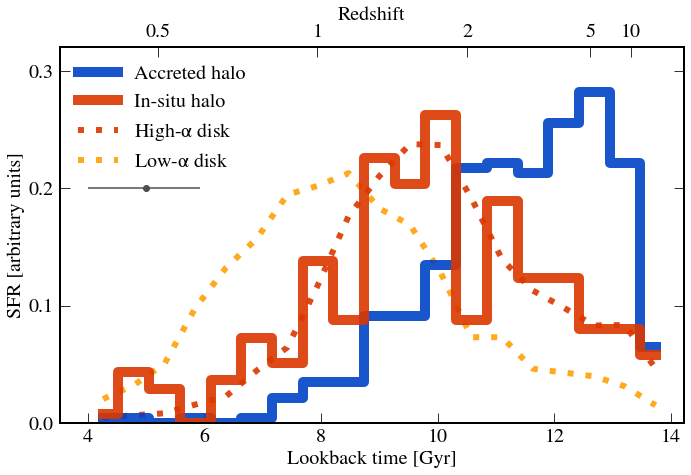

In [21]:
ivar = age_err**-1
ivar = np.ones_like(age_err)
abins = np.linspace(4,14,20)
# abins = np.linspace(3,15,22)
abcen = 0.5 * (abins[1:] + abins[:-1])

ind_thick_ = ind_tdchem & (t['eccen_pot1']<0.5)

h_accreted, be = np.histogram(age[ind_safeage & ind_ge], weights=ivar[ind_safeage & ind_ge], bins=abins,
                              density=True)
h_insitu, be = np.histogram(age[ind_safeage & ind_splash], weights=ivar[ind_safeage & ind_splash], bins=abins,
                              density=True)
h_higha, be = np.histogram(age[ind_safeage & ind_thick_], weights=ivar[ind_safeage & ind_thick_], bins=abins,
                              density=True)
h_lowa, be = np.histogram(age[ind_safeage & ind_lowa], weights=ivar[ind_safeage & ind_lowa], bins=abins,
                              density=True)

plt.figure(figsize=(10,7))

plt.plot(abcen, h_accreted, color=blue, lw=10, alpha=0.9, drawstyle='steps-mid', label='Accreted halo')
plt.plot(abcen, h_insitu, color=orange, lw=10, alpha=0.9, drawstyle='steps-mid', label='In-situ halo')
plt.plot(abcen, h_higha, color=orange, lw=6, alpha=0.9, ls=':', dashes=[1,2], drawstyle='default', zorder=0,
         label='High-$\\alpha$ disk')
plt.plot(abcen, h_lowa, color=gold, lw=6, alpha=0.9, ls=':', dashes=[1,2], drawstyle='default', zorder=0,
         label='Low-$\\alpha$ disk')

plt.errorbar(np.array([5]), np.array([0.2]), yerr=None,
             xerr=np.array([np.median(age_lerr[ind_safeage]), np.median(age_uerr[ind_safeage])])[:,np.newaxis],
             fmt='o', color='0.3', capsize=0)

plt.ylim(0,0.32)
plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
plt.legend(loc=2, frameon=False )
plt.xlabel('Lookback time [Gyr]')
plt.ylabel('SFR [arbitrary units]')

ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(lookback)
ax2.set_xticklabels(zlabel)
ax2.set_xlabel('Redshift')

plt.tight_layout()
plt.savefig('../paper/ages.pdf')

In [22]:
for ind in [ind_ge, ind_splash, ind_thick, ind_lowa]:
    print(np.sum(ind_safeage & ind))

438
266
4631
1818


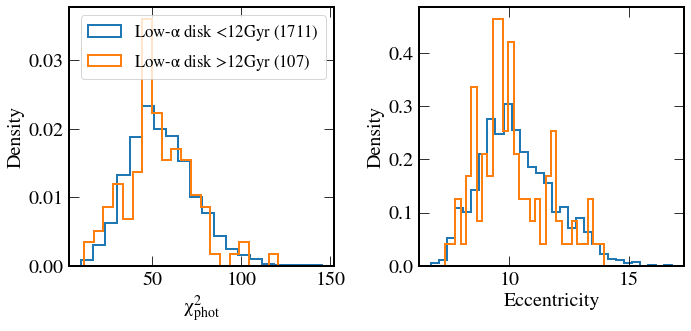

In [43]:
ind_old = age>12

fig, ax = plt.subplots(1,2,figsize=(10,5))

plt.sca(ax[0])
plt.hist(t['chisq_phot'][ind_safeage & ind_lowa & ~ind_old], histtype='step', bins=20, density=True, lw=2,
        label='Low-$\\alpha$ disk <12Gyr ({:d})'.format(np.sum(ind_safeage & ind_lowa & ~ind_old)))
plt.hist(t['chisq_phot'][ind_safeage & ind_lowa & ind_old], histtype='step', bins=20, density=True, lw=2,
        label='Low-$\\alpha$ disk >12Gyr ({:d})'.format(np.sum(ind_safeage & ind_lowa & ind_old)))

plt.legend(fontsize='small')
plt.xlabel('$\chi^2_{phot}$')
plt.ylabel('Density')

plt.sca(ax[1])
plt.hist(t['Rapo_pot1'][ind_safeage & ind_lowa & ~ind_old], histtype='step', bins=30, density=True, lw=2,
        label='Low-$\\alpha$ disk <12Gyr ({:d})'.format(np.sum(ind_safeage & ind_lowa & ~ind_old)))
plt.hist(t['Rapo_pot1'][ind_safeage & ind_lowa & ind_old], histtype='step', bins=30, density=True, lw=2,
        label='Low-$\\alpha$ disk >12Gyr ({:d})'.format(np.sum(ind_safeage & ind_lowa & ind_old)))

# plt.legend(fontsize='small')
plt.xlabel('Eccentricity')
plt.ylabel('Density')


plt.tight_layout()
# plt.savefig('../plots/chisq_phot_lowa.png')

In [58]:
'{:e}'.format(10**8.43)

'2.691535e+08'

In [56]:
for age_old in [10,11,12]:
    ind = age>age_old
    print(age_old, np.sum(ind_safeage & ind_lowa & ind)/np.sum(ind_safeage & ind_lowa))

10 0.20077007700770078
11 0.11551155115511551
12 0.05885588558855886


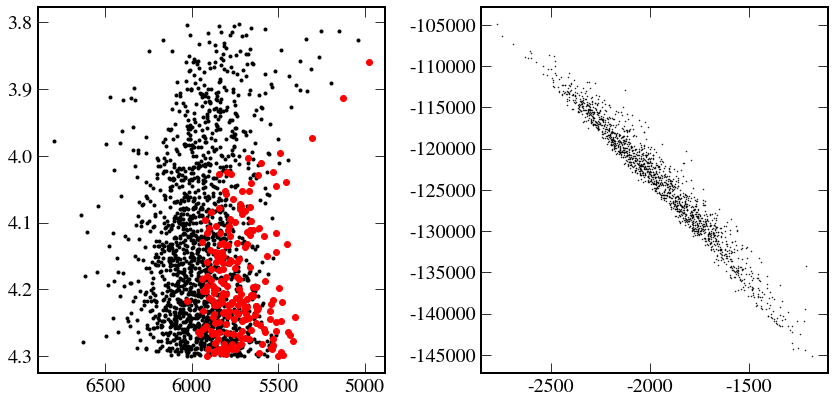

In [54]:
ind_old = age>11
fig, ax = plt.subplots(1,2,figsize=(12,6))

plt.sca(ax[0])
plt.plot(t['Teff'][ind_safeage & ind_lowa & ~ind_old], 
         t['logg'][ind_safeage & ind_lowa & ~ind_old], 'k.')
plt.plot(t['Teff'][ind_safeage & ind_lowa & ind_old], 
         t['logg'][ind_safeage & ind_lowa & ind_old], 'ro')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.sca(ax[1])
plt.plot(t['Lz'][ind_safeage & ind_lowa & ~ind_old], 
         t['E_tot_pot1'][ind_safeage & ind_lowa & ~ind_old], 'k.', ms=1)
# plt.plot(t['Lz'][ind_safeage & ind_lowa & ind_old], 
#          t['E_tot_pot1'][ind_safeage & ind_lowa & ind_old], 'ro', ms=2)

plt.tight_layout()

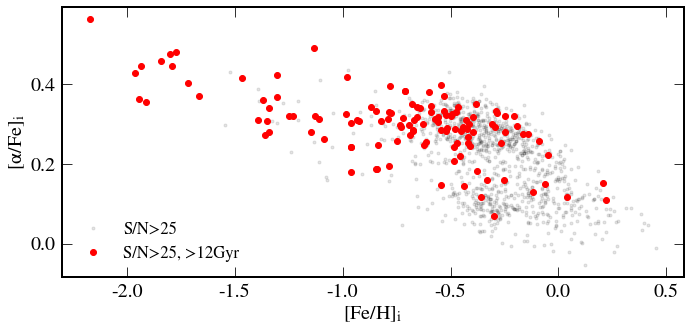

In [24]:
ind_highsnr = t['SNR']>25
ind_old = age>12

plt.figure(figsize=(10,5))
# plt.plot(t['init_FeH'][ind_safeage & ind_lowa & ~ind_old],
#          t['init_aFe'][ind_safeage & ind_lowa & ~ind_old], 'k.', alpha=0.1)
plt.plot(t['init_FeH'][ind_safeage & ind_highsnr],
         t['init_aFe'][ind_safeage & ind_highsnr], 'k.', alpha=0.1, label='S/N>25')
plt.plot(t['init_FeH'][ind_safeage & ind_old & ind_highsnr],
         t['init_aFe'][ind_safeage & ind_old & ind_highsnr], 'ro', label='S/N>25, >12Gyr')

plt.legend(fontsize='small', loc=3, frameon=False)
plt.xlabel('[Fe/H]$_i$')
plt.ylabel('[$\\alpha$/Fe]$_i$')

plt.tight_layout()
plt.savefig('../plots/afeh_old_highsnr.png')

1.4591814409117998


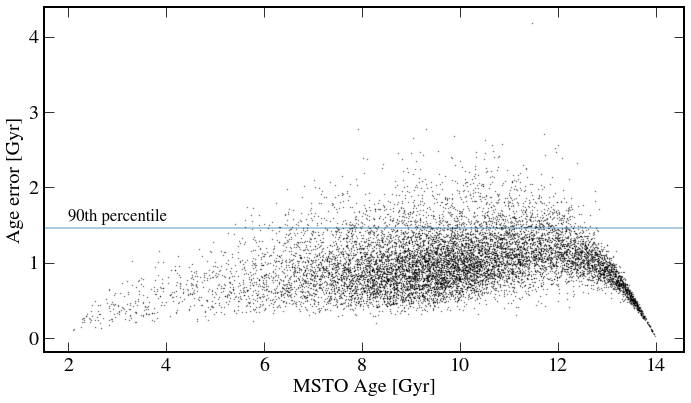

In [80]:
plt.figure(figsize=(10,6))

plt.plot(age[ind_safeage], age_err[ind_safeage], 'k.', ms=1, alpha=0.5)

p90 = np.percentile(age_err[ind_safeage], [90])[0]
print(p90)
plt.axhline(p90, color='tab:blue', alpha=0.5, zorder=0)
plt.text(2,p90+0.1, '90th percentile', fontsize='small')

plt.xlabel('MSTO Age [Gyr]')
plt.ylabel('Age error [Gyr]')
plt.tight_layout()
plt.savefig('../plots/age_precision.png')

In [86]:
for i in [1,10,20]:
    print((i*u.microhertz).to(u.day**-1))

0.0864 1 / d
0.8640000000000001 1 / d
1.7280000000000002 1 / d


In [25]:
z_ = 1
logM = 10.7-0.045*z_-0.13*z_**2
print('{:e}'.format(10**logM))

3.349654e+10


In [26]:
scipy.stats.ks_2samp(age[ind_safeage & ind_splash], age[ind_safeage & ind_thick])

Ks_2sampResult(statistic=0.06703516510992445, pvalue=0.19871831278148044)

In [27]:
np.sum(ind_safeage & ind_lowa & (age>10))/np.sum(ind_safeage & ind_lowa)

0.20077007700770078

## Figure 5: SFH models

In [28]:
def f_ramp(x, x1, x2):
    if x2<x1:
        x_ = x2
        x2 = x1
        x1 = x_
    dx = x2-x1
    k = -2 * dx**-2
    l = 2/dx * (1 + x1/dx)
    
    fx = k*x + l
    ind = (x>=x1) & (x<=x2)
    fx[~ind] = 0

    return fx

def pdf_ramp(u, x1, x2):
    if x2<x1:
        x_ = x2
        x2 = x1
        x1 = x_
    dx = x2-x1
    k = -2 * dx**-2
    l = 2/dx * (1 + x1/dx)
    
    x = -np.sqrt((x1 + l/k)**2 + 2*u/k) - l/k
    
    return x

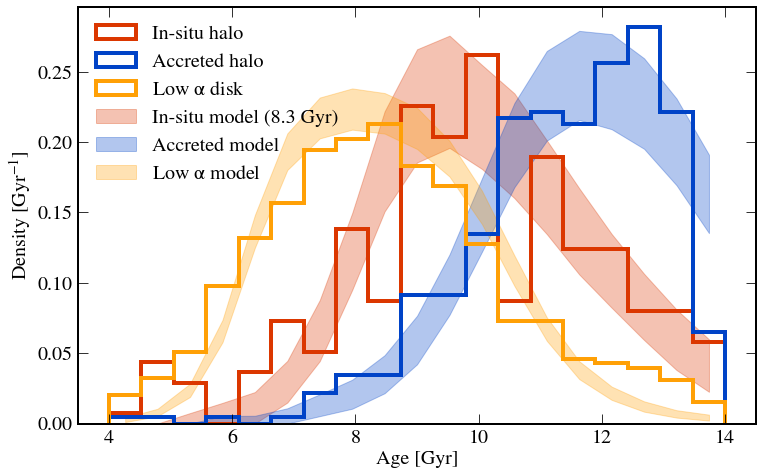

In [29]:
nacc = np.sum(ind_safeage & ind_ge)
obs_acc = age[ind_safeage & ind_ge]
err_acc = age_err[ind_safeage & ind_ge]

nins = np.sum(ind_safeage & ind_splash)
obs_ins = age[ind_safeage & ind_splash]
err_ins = age_err[ind_safeage & ind_splash]

nlow = np.sum(ind_safeage & ind_lowa)
obs_low = age[ind_safeage & ind_lowa]
err_low = age_err[ind_safeage & ind_lowa]

np.random.seed(4629)

nboot = 1000
nbin = np.size(abins) - 1
bcen = 0.5 * (abins[1:] + abins[:-1])
h_age_acc = np.empty((nboot, nbin))
h_age_ins = np.empty((nboot, nbin))
h_age_ins1 = np.empty((nboot, nbin))
h_age_ins2 = np.empty((nboot, nbin))
h_age_low = np.empty((nboot, nbin))

h_age_ins_list = [h_age_ins1, h_age_ins, h_age_ins2]

f = 0.4
n1 = int(nacc*f)
n2 = nacc - n1

for i in range(nboot):
    # sample accreted halo from a flat distribution
    model_acc = np.random.rand(nacc)*3.7 + 10.3
#     model_acc = np.concatenate([np.ones(n1)*11, np.ones(n2)*13])
#     model_acc_conv = np.random.randn(nacc)*np.random.permutation(err_acc) + np.random.permutation(model_acc)
    log_model_acc = np.log10(model_acc)
    log_model_acc_conv = (np.random.randn(nacc)*np.random.permutation(t['logAge_lerr'][ind_safeage & ind_ge])
                          + np.random.permutation(log_model_acc))
    model_acc_conv = 10**log_model_acc_conv
    h, be = np.histogram(model_acc_conv, bins=abins, density=True)
    h_age_acc[i] = h
    
    # sample low alpha disk from a flat distribution
    model_low = np.random.rand(nlow)*4.3 + 6.3
    log_model_low = np.log10(model_low)
    rand_log_model_low = np.random.permutation(log_model_low)
    ind_sort_model = np.argsort(rand_log_model_low)
    rand_err = np.random.permutation(t['logAge_lerr'][ind_safeage & ind_lowa])
    ind_sort_err = np.argsort(rand_err)
    log_model_low_conv = (np.random.randn(nlow)*rand_err[:]
                          + rand_log_model_low[:])
#     log_model_low_conv = (np.random.randn(nlow)*rand_err[ind_sort_err]
#                           + rand_log_model_low[ind_sort_model])
    model_low_conv = 10**log_model_low_conv
    h, be = np.histogram(model_low_conv, bins=abins, density=True)
    h_age_low[i] = h
    
    # sample in-situ halo from a narrow gaussian
#     model_u = np.random.rand(nins)
#     model_ins = pdf_ramp(model_u, 8.3, 14)
#     log_model_ins = np.log10(model_ins)
#     log_model_ins_conv = (np.random.randn(nins)*np.random.permutation(t['logAge_lerr'][ind_safeage & ind_splash])
#                           + np.random.permutation(log_model_ins))
#     model_ins_conv = 10**log_model_ins_conv
#     h, be = np.histogram(model_ins_conv, bins=abins, density=True)
#     h_age_ins[i] = h
    
    # multiple in-situ choices:
    for e, age_lim in enumerate([7.3,8.3,9.3]):
        model_u = np.random.rand(nins)
        model_ins = pdf_ramp(model_u, age_lim, 14)
        log_model_ins = np.log10(model_ins)
        log_model_ins_conv = (np.random.randn(nins)*np.random.permutation(t['logAge_lerr'][ind_safeage & ind_splash])
                              + np.random.permutation(log_model_ins))
        model_ins_conv = 10**log_model_ins_conv
        h, be = np.histogram(model_ins_conv, bins=abins, density=True)
        h_age_ins_list[e][i] = h


model_acc_dn, model_acc_up = np.percentile(h_age_acc, [16,84], axis=0)
model_ins_dn, model_ins_up = np.percentile(h_age_ins, [16,84], axis=0)
model_ins1_dn, model_ins1_up = np.percentile(h_age_ins1, [16,84], axis=0)
model_ins2_dn, model_ins2_up = np.percentile(h_age_ins2, [16,84], axis=0)
model_low_dn, model_low_up = np.percentile(h_age_low, [16,84], axis=0)

plt.figure(figsize=(11,7))

plt.hist(obs_ins, bins=abins, color=orange, histtype='step', lw=4, density=True, label='In-situ halo')
# plt.fill_between(bcen, model_ins1_dn, model_ins1_up, color='darkorange', alpha=0.3, label='In-situ model (7.3 Gyr)')
plt.fill_between(bcen, model_ins_dn, model_ins_up, color=orange, alpha=0.3, label='In-situ model (8.3 Gyr)')
# plt.fill_between(bcen, model_ins2_dn, model_ins2_up, color='red', alpha=0.3, label='In-situ model (9.3 Gyr)')

plt.hist(obs_acc, bins=abins, color=blue, histtype='step', lw=4, density=True, label='Accreted halo')
plt.fill_between(bcen, model_acc_dn, model_acc_up, color=blue, alpha=0.3, label='Accreted model')

plt.hist(obs_low, bins=abins, color=gold, histtype='step', lw=4, density=True, label='Low $\\alpha$ disk')
plt.fill_between(bcen, model_low_dn, model_low_up, color=gold, alpha=0.3, label='Low $\\alpha$ model')

plt.legend(loc=2, frameon=False)
plt.xlabel('Age [Gyr]')
plt.ylabel('Density [Gyr$^{-1}$]')

plt.tight_layout()
plt.savefig('../plots/ages_model_delta.png')

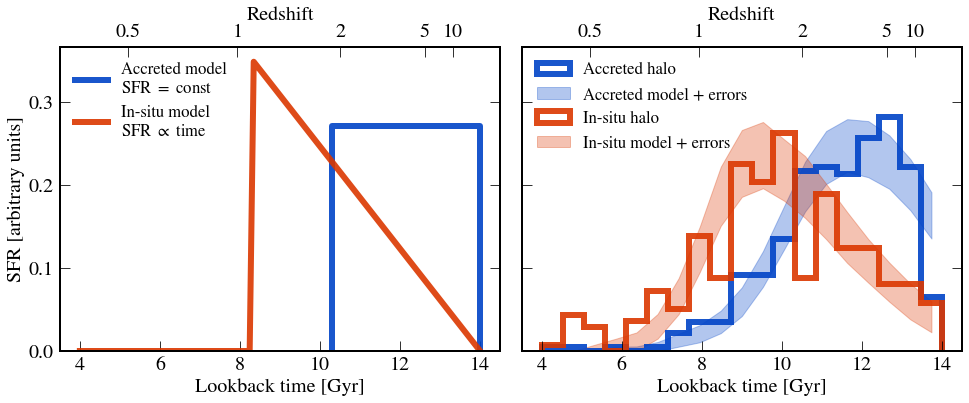

In [83]:
fig, ax = plt.subplots(1,2,figsize=(14,6), sharex=True, sharey=True)

plt.sca(ax[0])
y = 1/3.7
x_ = np.array([10.3, 10.3, 14, 14])
y_ = np.array([0, y, y, 0])
plt.plot(x_, y_, '-', color=blue, lw=6, alpha=0.9, label='Accreted model\nSFR $=$ const')

x_ = np.linspace(4,14,100)
y_ = f_ramp(x_, 8.3, 14)
plt.plot(x_, y_, '-', color=orange, lw=6, alpha=0.9, label='In-situ model\nSFR $\propto$ time')

plt.legend(loc=2, frameon=False, fontsize='small')
plt.xlabel('Lookback time [Gyr]')
plt.ylabel('SFR [arbitrary units]')

plt.sca(ax[1])
plt.hist(obs_acc, bins=abins, color=blue, histtype='step', lw=6, alpha=0.9, density=True, label='Accreted halo')
plt.fill_between(bcen, model_acc_dn, model_acc_up, color=blue, alpha=0.3, label='Accreted model + errors')

plt.hist(obs_ins, bins=abins, color=orange, histtype='step', lw=6, alpha=0.9, density=True, label='In-situ halo')
plt.fill_between(bcen, model_ins_dn, model_ins_up, color=orange, alpha=0.3, label='In-situ model + errors')

handles, labels = plt.gca().get_legend_handles_labels()
order = np.array([0,2,1,3]).astype('int')
handles = [handles[x] for x in order]
labels = [labels[x] for x in order]
plt.legend(handles, labels, loc=2, frameon=False, fontsize='small')
plt.xlabel('Lookback time [Gyr]')

for ax1 in ax:
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(lookback)
    ax2.set_xticklabels(zlabel)
    ax2.set_xlabel('Redshift')

plt.tight_layout()
plt.savefig('../paper/ages_model.pdf')